In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
from utils import *


In [39]:
class BCM_Model(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        # learnable params
      #  self.weights = torch.normal(mean=0, std=(2 / n_in)**(1/2),size=(n_units, n_in), dtype=torch.float64) # http://arxiv.org/abs/1502.01852
        self.weights = torch.normal( mean=0, std=1, size=(n_units, n_in),dtype=torch.float64)
        self.threshold = torch.zeros(n_units)

        # tracking
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []
    
    def update(self, x, eps=1, dt=0.01):

        # update threshold
        y = torch.mm(self.weights, x) 
        self.threshold =  torch.mean(y**2, dim=1)
        t  = self.threshold.reshape(-1, 1)
        
        # calc weight update
        phi = y * (y - t) 
        delta_w =  torch.mm(phi, x.T)   - eps * self.weights
        delta_w /= batch_size # norm update with batchsize

        # update weights
        self.weights += delta_w * dt

      #  self.weights =  self.weights/torch.linalg.norm(self.weights)
        
        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

torch.Size([10, 100])
tensor([-1.1913e+33, -1.2907e+30,  2.1307e+25,  1.7314e+28, -2.7671e+30,
        -2.5652e+28, -2.5085e+21,  4.6736e+30,  2.1689e+34,  4.7890e+28],
       dtype=torch.float64)


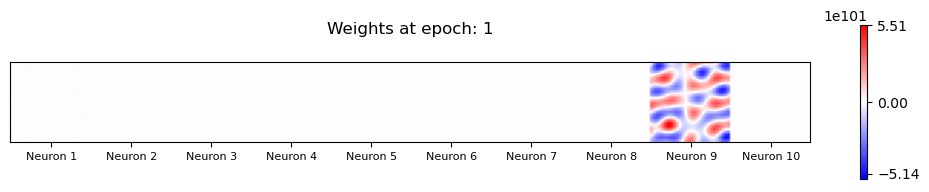

In [40]:
# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape



# hps#
n_epochs = 1
n_units = 10
batch_size = 100

model = BCM_Model(n_in, n_units)
#model = BCM_Model_Squadrani(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch)
        draw_weights(model.weights, epoch)



In [41]:
model.weights

tensor([[ -7.4169e-01,   2.6019e+98,   2.5105e+97,  ...,  -1.8249e+99,
          -1.1044e+99,  -1.7624e+99],
        [ -6.2344e-01,   9.3815e+89,   1.2790e+90,  ...,   7.2291e+90,
           9.3008e+90,   7.2459e+90],
        [  7.5804e-01,  -3.0810e+76,  -3.0224e+77,  ...,   3.8456e+77,
           7.9880e+77,   3.6449e+77],
        ...,
        [  6.0939e-02,  -5.4849e+90,  -8.3311e+90,  ...,   4.8533e+91,
           3.8108e+91,   2.3776e+91],
        [  3.5227e-01, -2.2742e+101, -3.7663e+101,  ..., -3.2527e+101,
         -3.6669e+101, -3.3054e+101],
        [ -4.4495e-02,  -8.3800e+84,  -1.2309e+85,  ...,   2.5247e+84,
          -2.1772e+84,  -1.5043e+84]], dtype=torch.float64)

### Visual Analysis

#### Selectivity

In [42]:
img = np.array(model.selectivity)
img =img.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

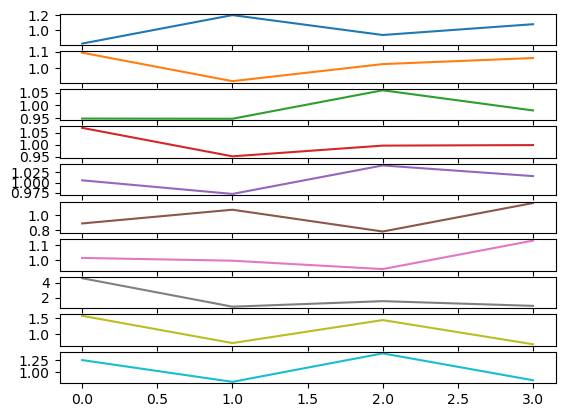

In [43]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': img[i,:] for i in range(n_units)})
df.plot(subplots=True, legend=False)

#### Threshold

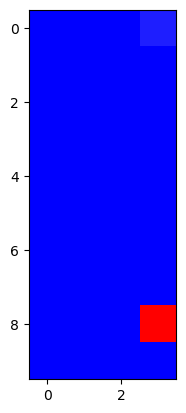

In [44]:
t = np.array(model.threshold_trace)
t = t.T
plt.imshow(t,cmap='bwr')

In [45]:
t.shape

(10, 4)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

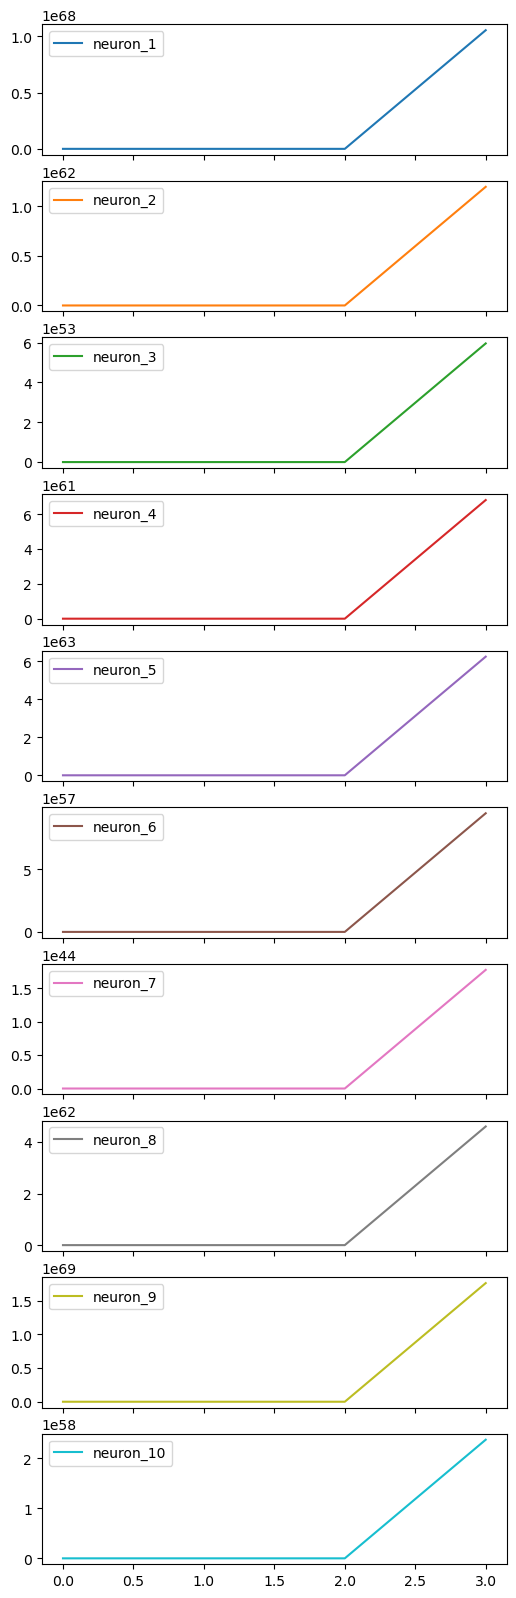

In [46]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': t[i, :] for i in range(n_units)})
df.plot(subplots=True, figsize=(6, n_units*2))


#### Activations

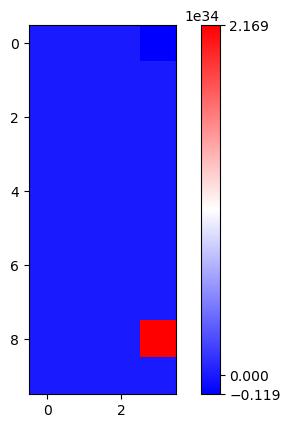

In [47]:
y = np.array(model.activations)
y = y.T
plt.imshow(y,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])

In [48]:
y.shape

(10, 4)

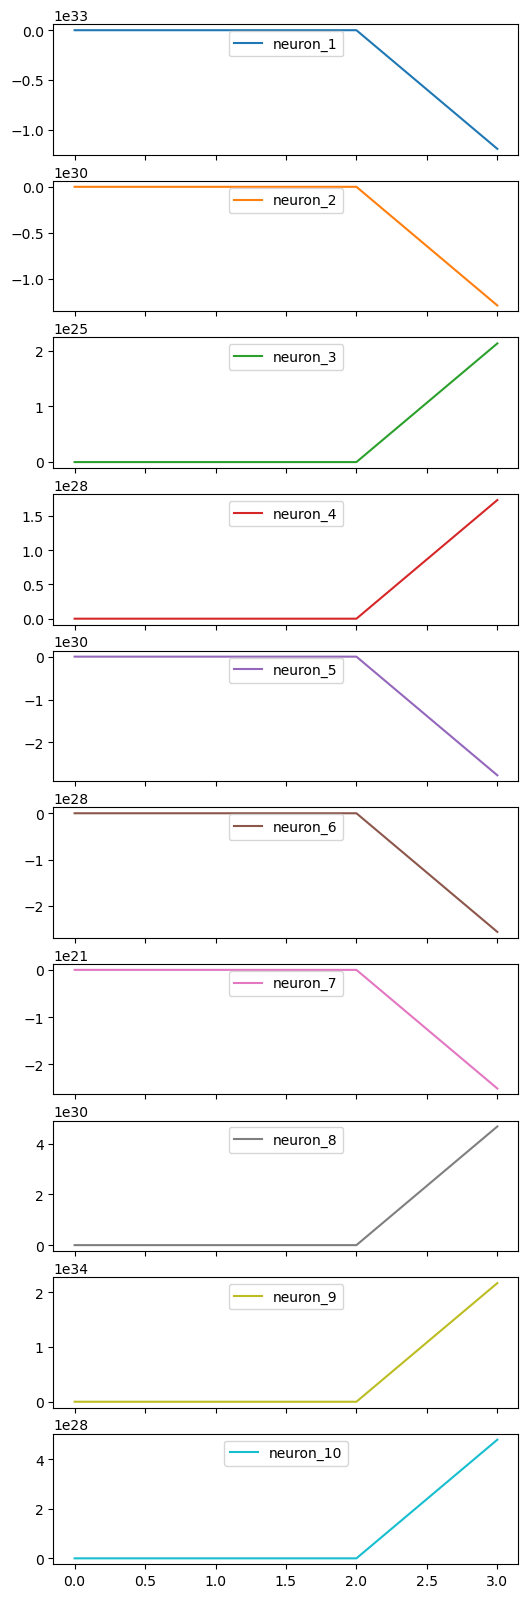

In [49]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': y[i, :] for i in range(n_units)})

# plot the data with subplots and assign the returned array
axes = df.plot(subplots=True,figsize=(6, n_units*2))

# flatten the array
axes = axes.flat  # .ravel() and .flatten() also work

# extract the figure object to use figure level methods

# iterate through each axes to use axes level methods
for ax in axes:
    
    ax.legend(loc='upper center', )
    


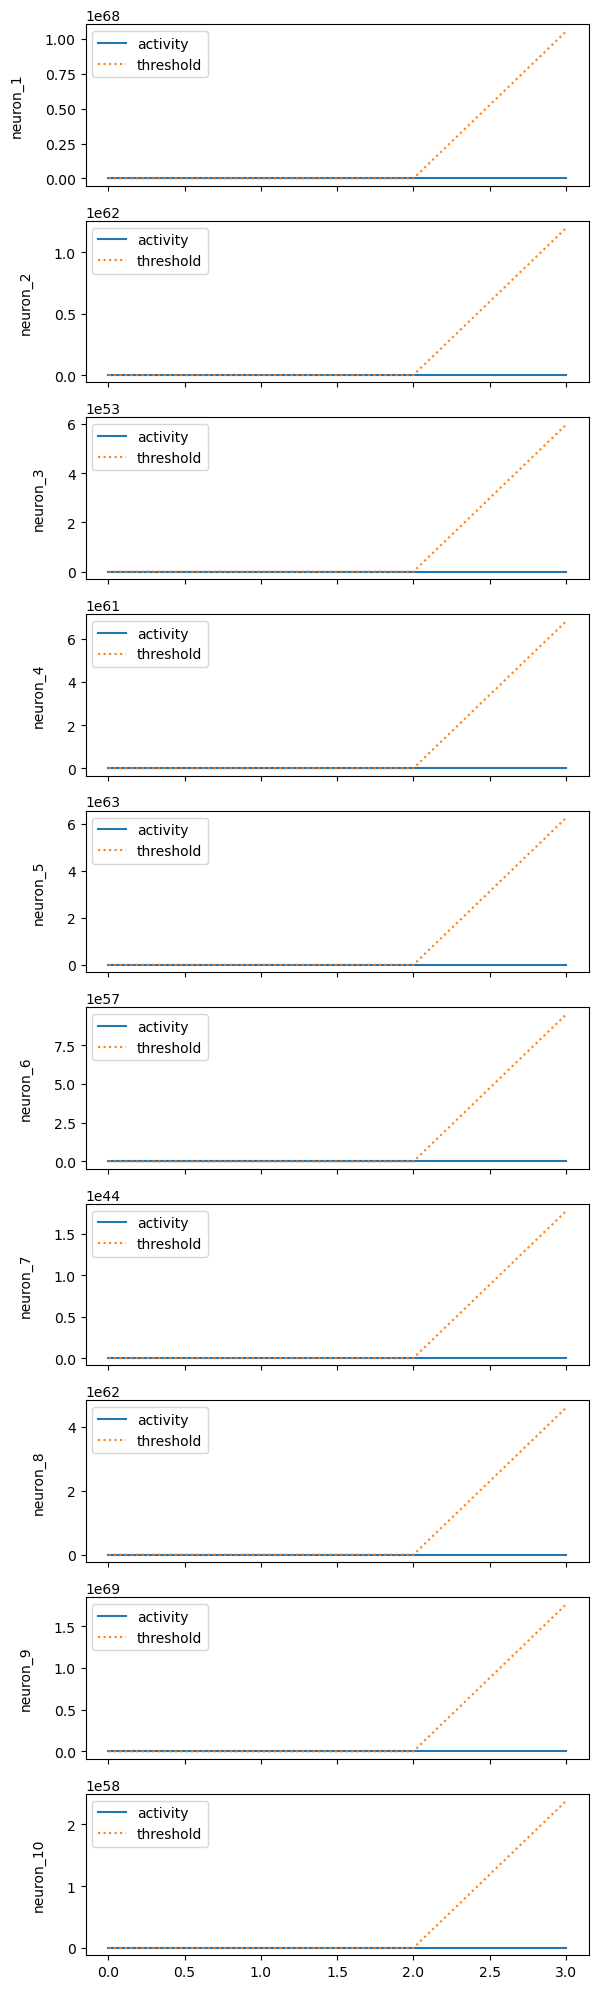

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y and t are numpy arrays of shape (n_units, timepoints)
n_units = y.shape[0]

# Create subplots
fig, axes = plt.subplots(n_units, 1, figsize=(6, n_units*2), sharex=True)

# Loop over neurons
for i in range(n_units):
    ax = axes[i]
    
    # Plot activity
    ax.plot(y[i, :], label='activity')
    
    # Plot threshold (dotted)
    ax.plot(t[i, :], linestyle=':', label='threshold')
    
    # Set y-label as neuron label
    ax.set_ylabel(f'neuron_{i+1}', rotation=90, labelpad=20, va='center')
    
    # Optionally remove legend if labels are clear
    ax.legend()

plt.tight_layout()
plt.show()


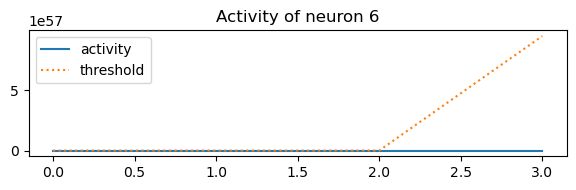

In [51]:
import matplotlib.pyplot as plt

# Select neuron index 5 (6th neuron)
i = 5

fig, ax = plt.subplots(figsize=(6, 2))

# Plot activity
ax.plot(y[i, :], label='activity')

# Plot threshold (dotted)
ax.plot(t[i, :], linestyle=':', label='threshold')

# Set y-label as neuron label
#x.set_ylabel(f'neuron_{i}', rotation=0, labelpad=40, va='center')
# Add legend
plt.title(f"Activity of neuron {i+1}")
ax.legend()

plt.tight_layout()
plt.show()


#### Comparing Threshold & Activity 

In [52]:
import seaborn as sns

In [53]:
y.shape

(10, 4)

In [54]:
y[i,:]

array([ 3.77326244e+00, -2.97159237e+02,  1.40232232e+09, -2.56523615e+28])

In [55]:
t[i,:]

array([2.90232507e+02, 5.11332875e+06, 3.36538090e+19, 9.46251282e+57])

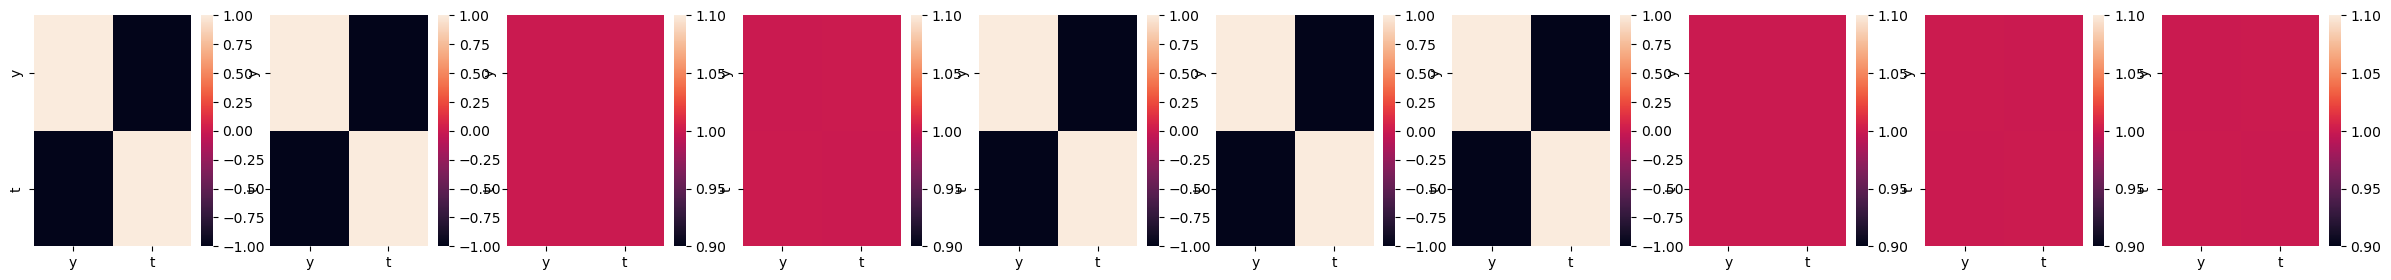

In [56]:
n_cols = n_units  # number of columns in subplot grid
n_rows = 1 # compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(n_units):
    df = pd.DataFrame({'y':y[i,:], 't':t[i,:]})
    cor = df.corr()
    sns.heatmap(cor, ax= axes[i])